In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [102]:
pd.options.display.float_format = '{:,.2f}'.format
data=pd.read_csv("Health_insurance.csv")
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,"16,884.92"
1,18,male,33.77,1,no,southeast,"1,725.55"
2,28,male,33.00,3,no,southeast,"4,449.46"
3,33,male,22.70,0,no,northwest,"21,984.47"
4,32,male,28.88,0,no,northwest,"3,866.86"
...,...,...,...,...,...,...,...
1333,50,male,30.97,3,no,northwest,"10,600.55"
1334,18,female,31.92,0,no,northeast,"2,205.98"
1335,18,female,36.85,0,no,southeast,"1,629.83"
1336,21,female,25.80,0,no,southwest,"2,007.94"


1. the age of the person
2. gender of the person
3. Body Mass Index of the person
4. how many children the person is having
5. whether the person smokes or not
6. the region where the person lives
7. the charges of the insurance premium

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [104]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## EDA, cleaning and visualizations

In [105]:
data.describe()

,age,bmi,children,charges
count,"1,338.00","1,338.00","1,338.00","1,338.00"
mean,39.21,30.66,1.09,"13,270.42"
std,14.05,6.10,1.21,"12,110.01"
min,18.00,15.96,0.00,"1,121.87"
25%,27.00,26.30,0.00,"4,740.29"
50%,39.00,30.40,1.00,"9,382.03"
75%,51.00,34.69,2.00,"16,639.91"
max,64.00,53.13,5.00,"63,770.43"


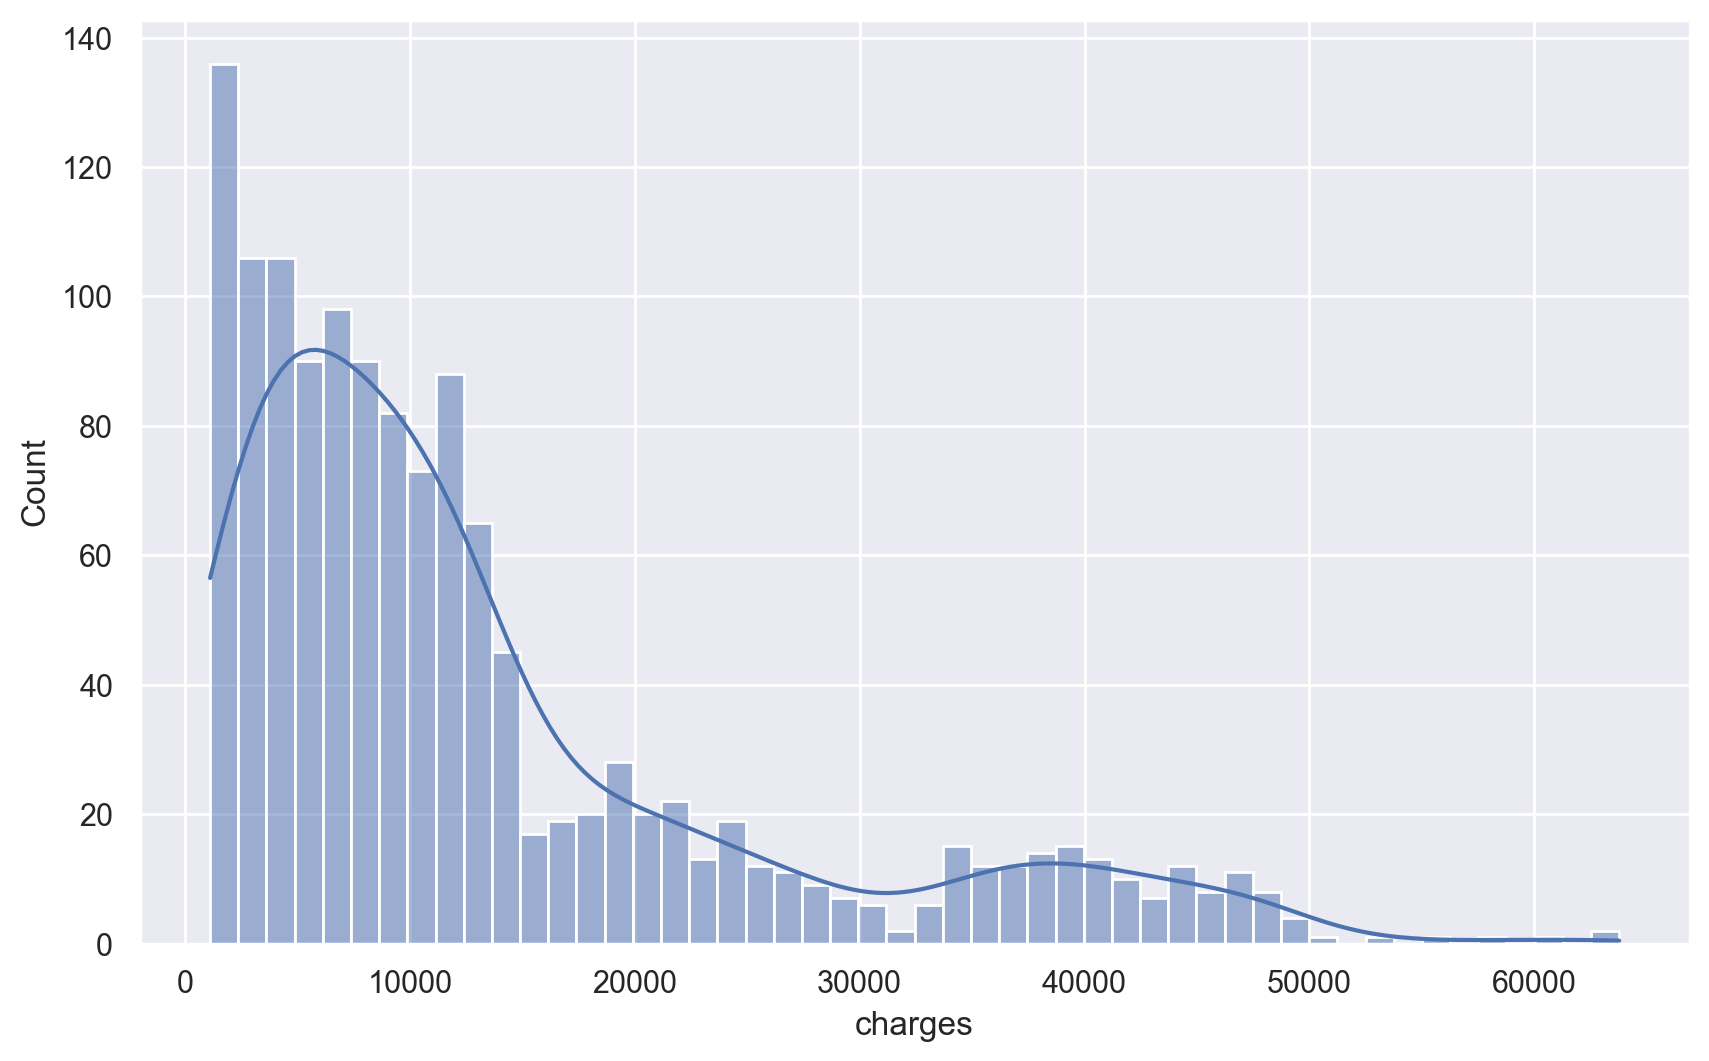

In [106]:
plt.figure(figsize=(10,6), dpi=200)
sns.histplot(data.charges, bins=50, kde=True);

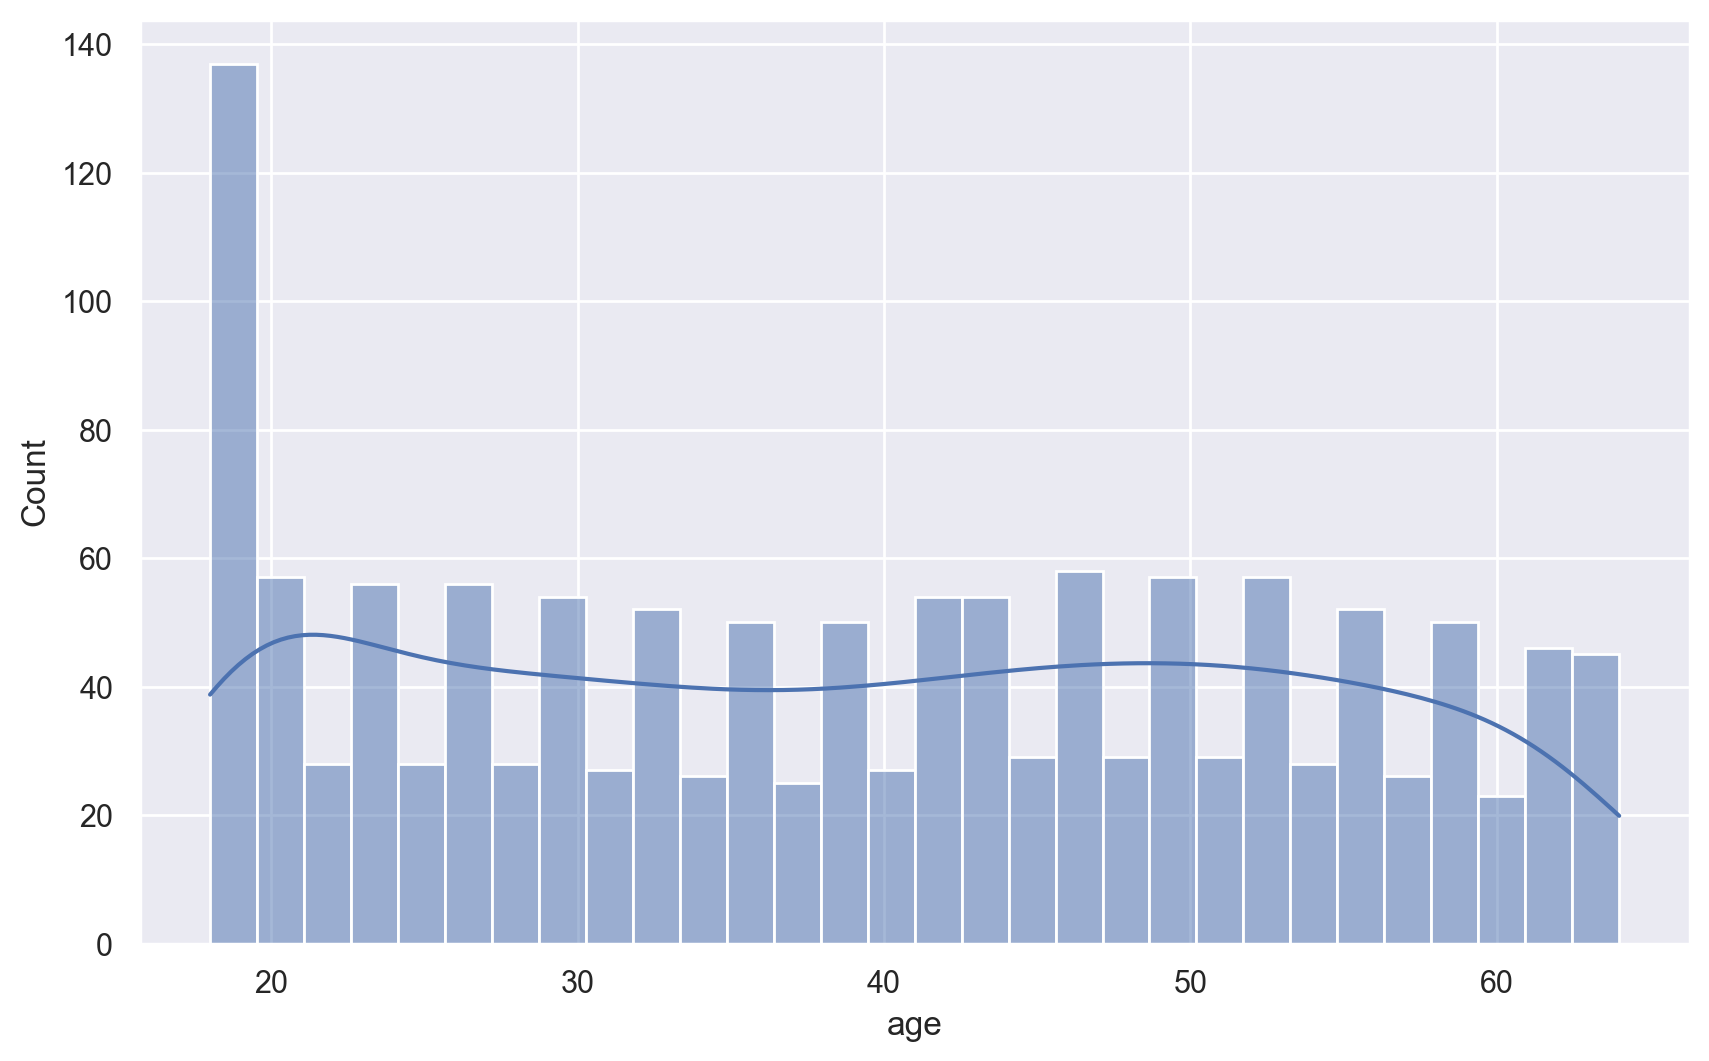

In [107]:
plt.figure(figsize=(10,6), dpi=200)
sns.histplot(data.age, bins=30, kde=True);

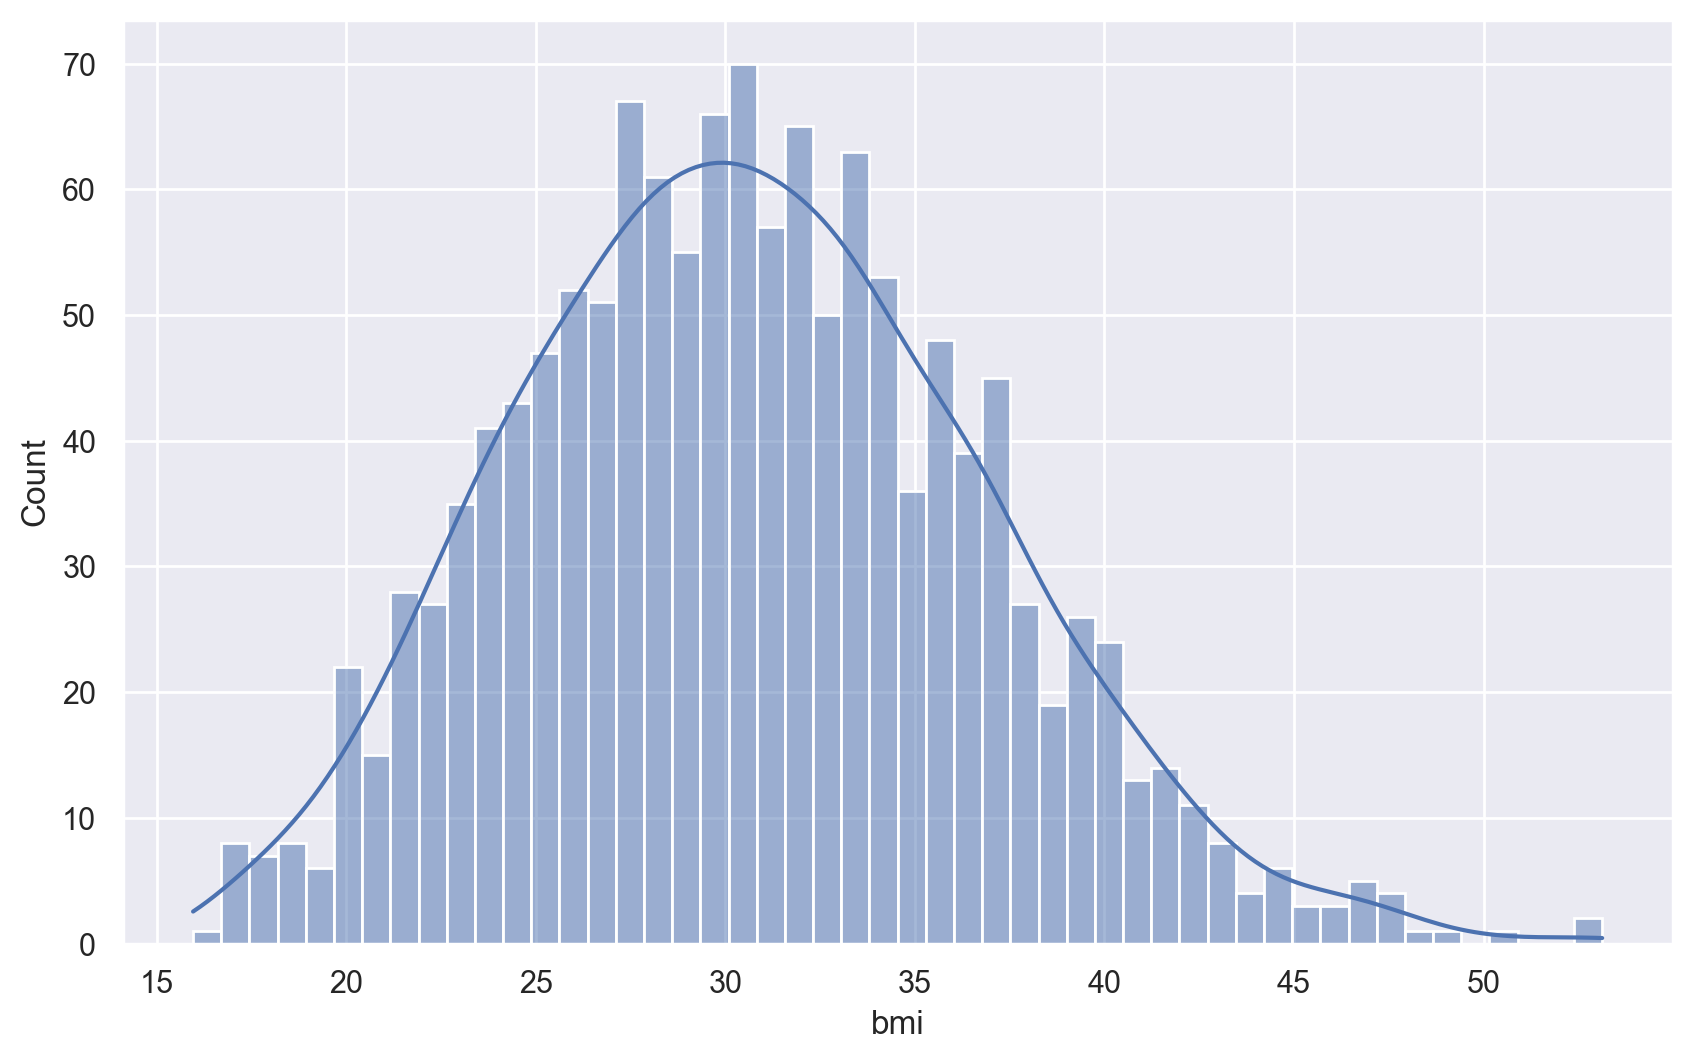

In [31]:
plt.figure(figsize=(10,6), dpi=200)
sns.histplot(data.bmi, bins=50, kde=True);

<Figure size 2000x1200 with 0 Axes>

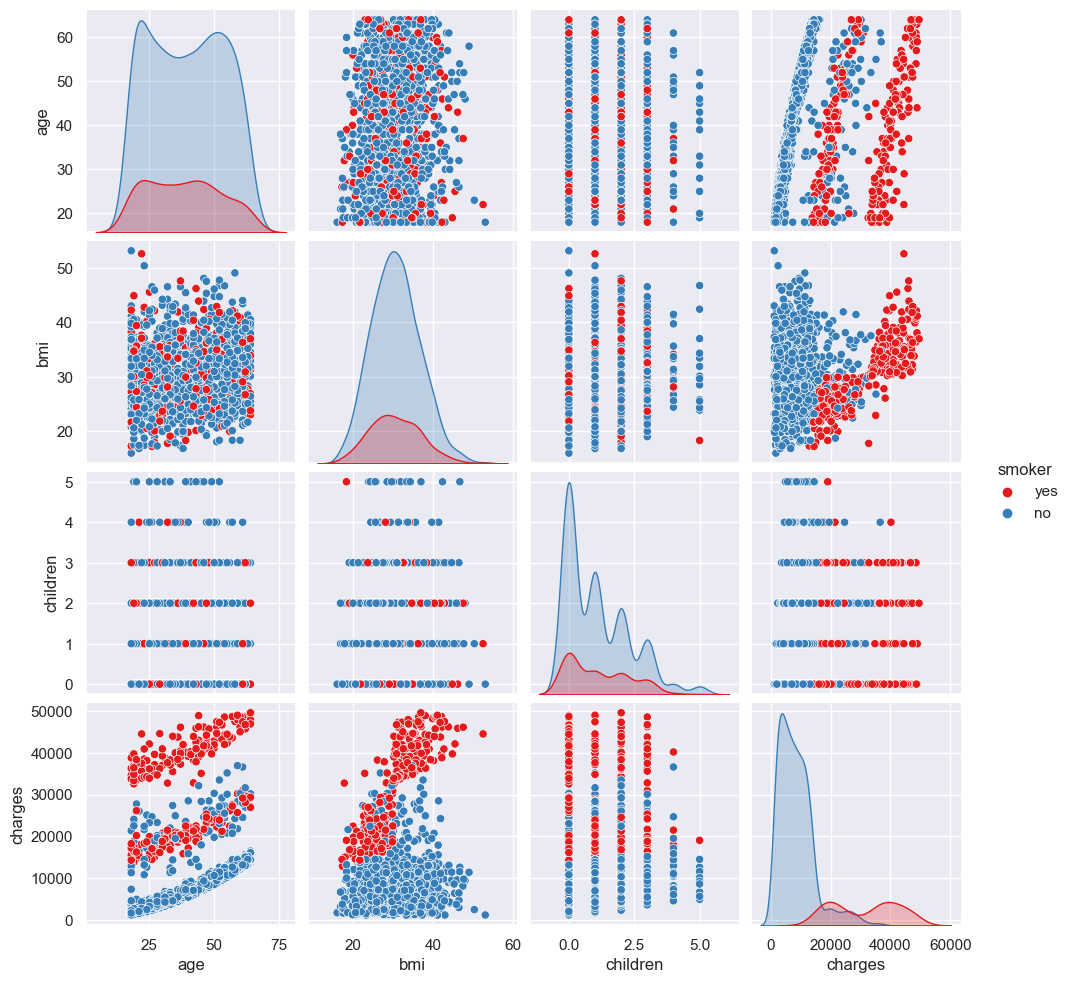

In [111]:
plt.figure(figsize=(10,6), dpi=200)
sns.pairplot(data,hue='smoker', palette='Set1')

In [109]:
data=data[data.charges<50000]

<Axes: >

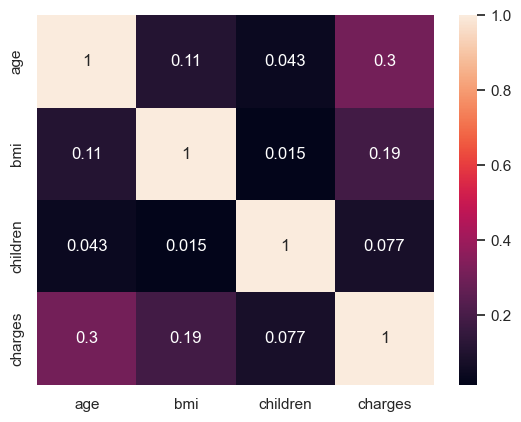

In [110]:
sns.heatmap(data.corr(), annot=True)

In [52]:
data=pd.get_dummies(data, drop_first=True)
data

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,"16,884.92",0,1,0,0,1
1,18,33.77,1,"1,725.55",1,0,0,1,0
2,28,33.00,3,"4,449.46",1,0,0,1,0
3,33,22.70,0,"21,984.47",1,0,1,0,0
4,32,28.88,0,"3,866.86",1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.97,3,"10,600.55",1,0,1,0,0
1334,18,31.92,0,"2,205.98",0,0,0,0,0
1335,18,36.85,0,"1,629.83",0,0,0,1,0
1336,21,25.80,0,"2,007.94",0,0,0,0,1


In [55]:
data.corr()['charges'].sort_values()

region_southwest   -0.05
region_northwest   -0.04
sex_male            0.06
region_southeast    0.07
children            0.08
bmi                 0.19
age                 0.30
smoker_yes          0.79
charges             1.00
Name: charges, dtype: float64

<Axes: >

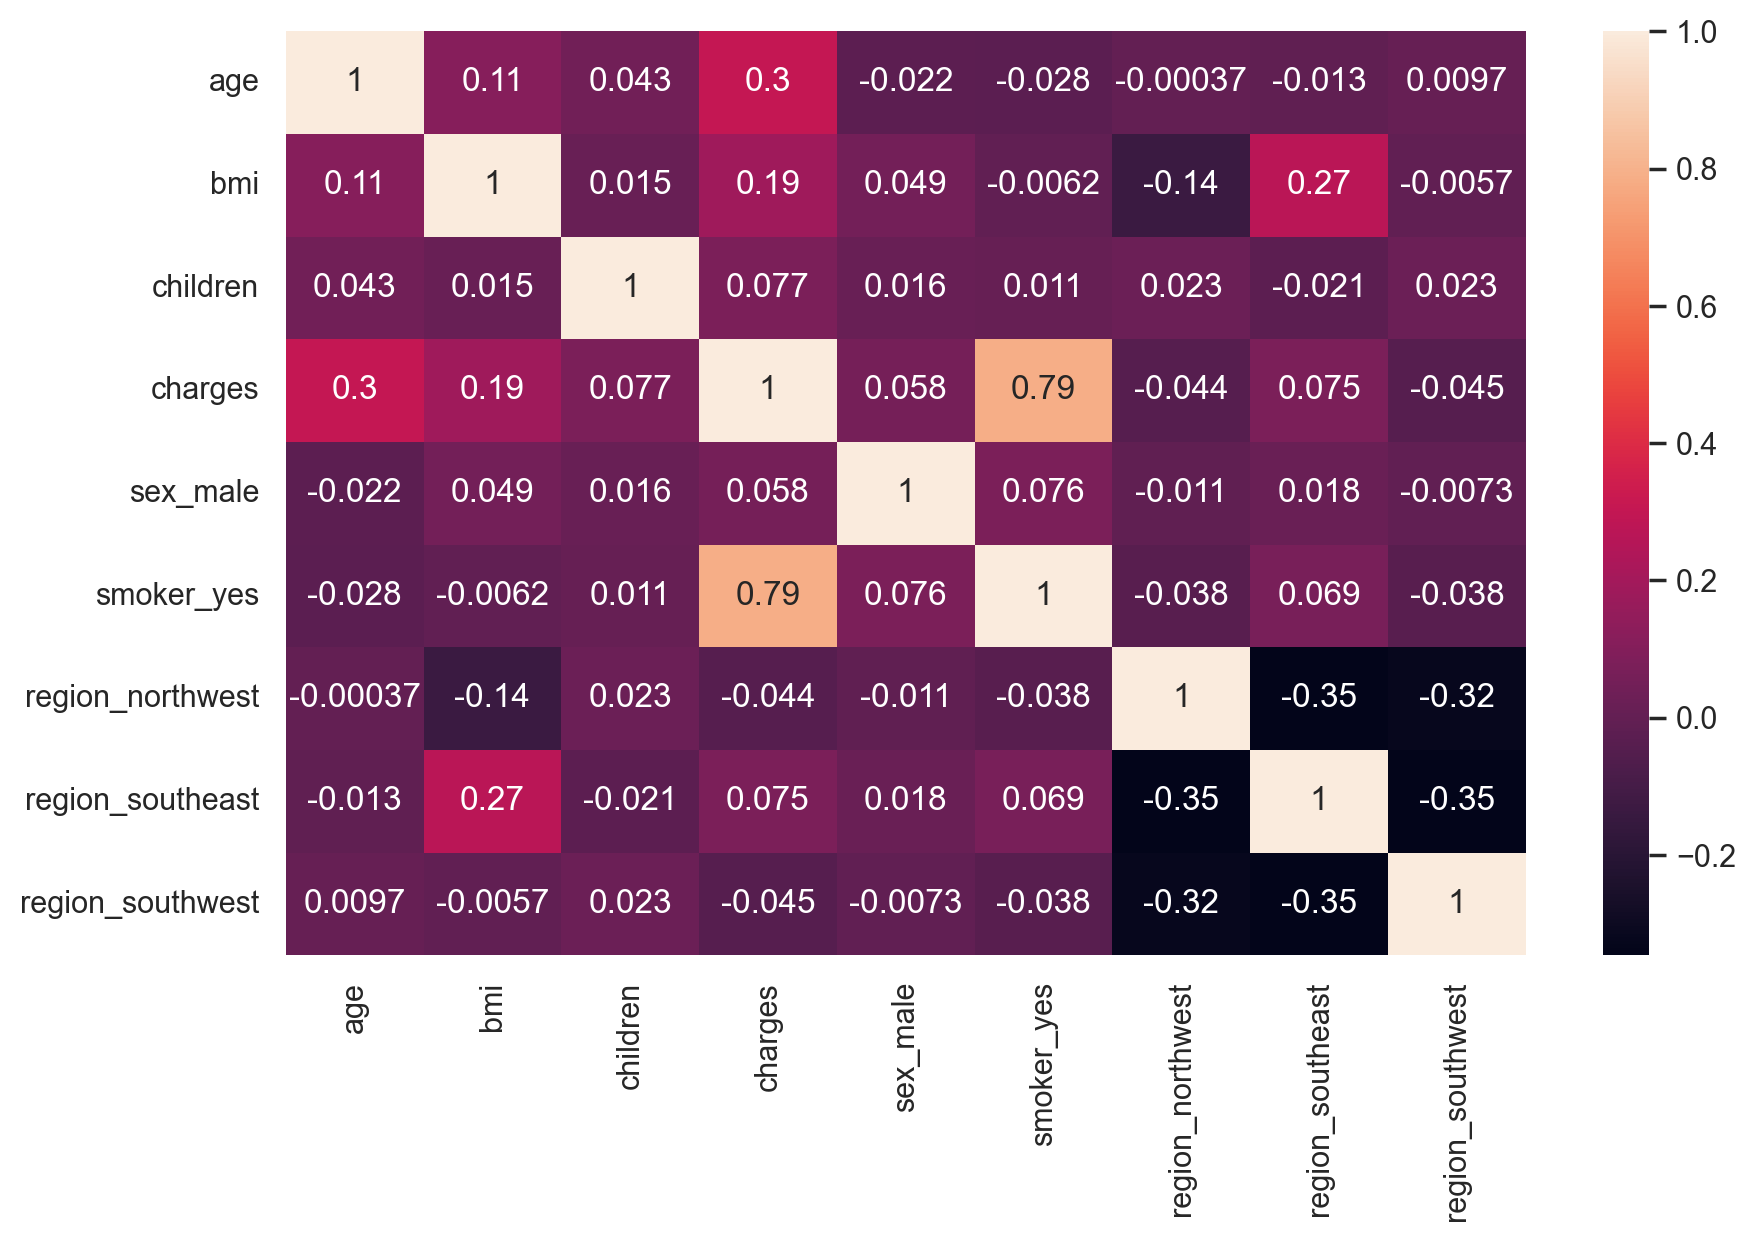

In [57]:
plt.figure(figsize=(10,6), dpi=200)
sns.heatmap(data.corr(), annot=True)

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [59]:
X=data.drop("charges",axis=1)
y=data["charges"]

In [60]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [61]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [78]:
def adj_R2(R2,n,k):
    return 1 - (1 - R2) * (n - 1) / (n - k - 1)

def performace_table(bayes_model, x_train, y_train,x_test, y_test):
    train_pred=bayes_model.predict(x_train)
    train_error=round(mean_absolute_error(y_train, train_pred)/y_train.mean()*100,2)
    train_R2=round(r2_score(y_train, train_pred)*100,2)
    train_adj_R2=round(adj_R2(train_R2/100,x_train.shape[0],x_train.shape[1])*100,2)
    test_pred=bayes_model.predict(x_test)
    test_error=round(mean_absolute_error(y_test, test_pred)/y_test.mean()*100,2)
    test_R2=round(r2_score(y_test, test_pred)*100,2)
    test_adj_R2=round(adj_R2(test_R2/100,x_test.shape[0],x_test.shape[1])*100,2)
    performace_table=pd.DataFrame()
    performace_table["Performance indicators"]=["Error percentage", "R2", "Adjusted_R2"]
    performace_table["On Training dataset"]=[train_error, train_R2, train_adj_R2]
    performace_table["On Test dataset"]=[test_error, test_R2, test_adj_R2]
    return performace_table

### Random Forest

In [87]:
forest_model = RandomForestRegressor()
forest_params={"n_estimators": Integer(100, 500),
               "max_depth": Integer(2,10),
               "max_features": Categorical(["sqrt", "log2"])}

forest_bayes=BayesSearchCV(forest_model, search_spaces=forest_params, cv=5, n_iter=100)
forest_bayes.fit(x_train, y_train)

c:\Users\Emil.Javadli\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Emil.Javadli\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Emil.Javadli\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Emil.Javadli\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Emil.Javadli\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective h

BayesSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
              search_spaces={'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize')})

In [88]:
performace_table(forest_bayes, x_train, y_train,x_test, y_test)

,Performance indicators,On Training dataset,On Test dataset
0,Error percentage,16.82,21.11
1,R2,90.12,86.10
2,Adjusted_R2,90.05,85.67


### XGBoost

In [69]:
xgb_model=xgb.XGBRegressor()
xgb_params={'n_estimators': Integer(50,500),
            'learning_rate': Real(0.01,0.2),
            'max_depth': Integer(3,6),
            'subsample':Real(0.5,1),
            'colsample_bytree': Real(0.5,1),
            'gamma': Real(0.1,6),
            'reg_alpha': Real(0.01,1),
            'reg_lambda': Real(1,8),
            'min_child_weight': Integer(2,6)
            }

In [85]:
bayes=BayesSearchCV(xgb_model, search_spaces=xgb_params, cv=5, n_iter=100)
bayes.fit(x_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                             'min_child_weight': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=1, high=8, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

In [89]:
bayes.best_params_

OrderedDict([('colsample_bytree', 1.0),
             ('gamma', 0.1),
             ('learning_rate', 0.10546837596272057),
             ('max_depth', 3),
             ('min_child_weight', 6),
             ('n_estimators', 50),
             ('reg_alpha', 0.3902253297691781),
             ('reg_lambda', 1.0),
             ('subsample', 0.8088669061062331)])

In [86]:
performace_table(bayes, x_train, y_train,x_test, y_test)

,Performance indicators,On Training dataset,On Test dataset
0,Error percentage,16.43,17.56
1,R2,87.91,87.07
2,Adjusted_R2,87.82,86.67


<Axes: xlabel='charges'>

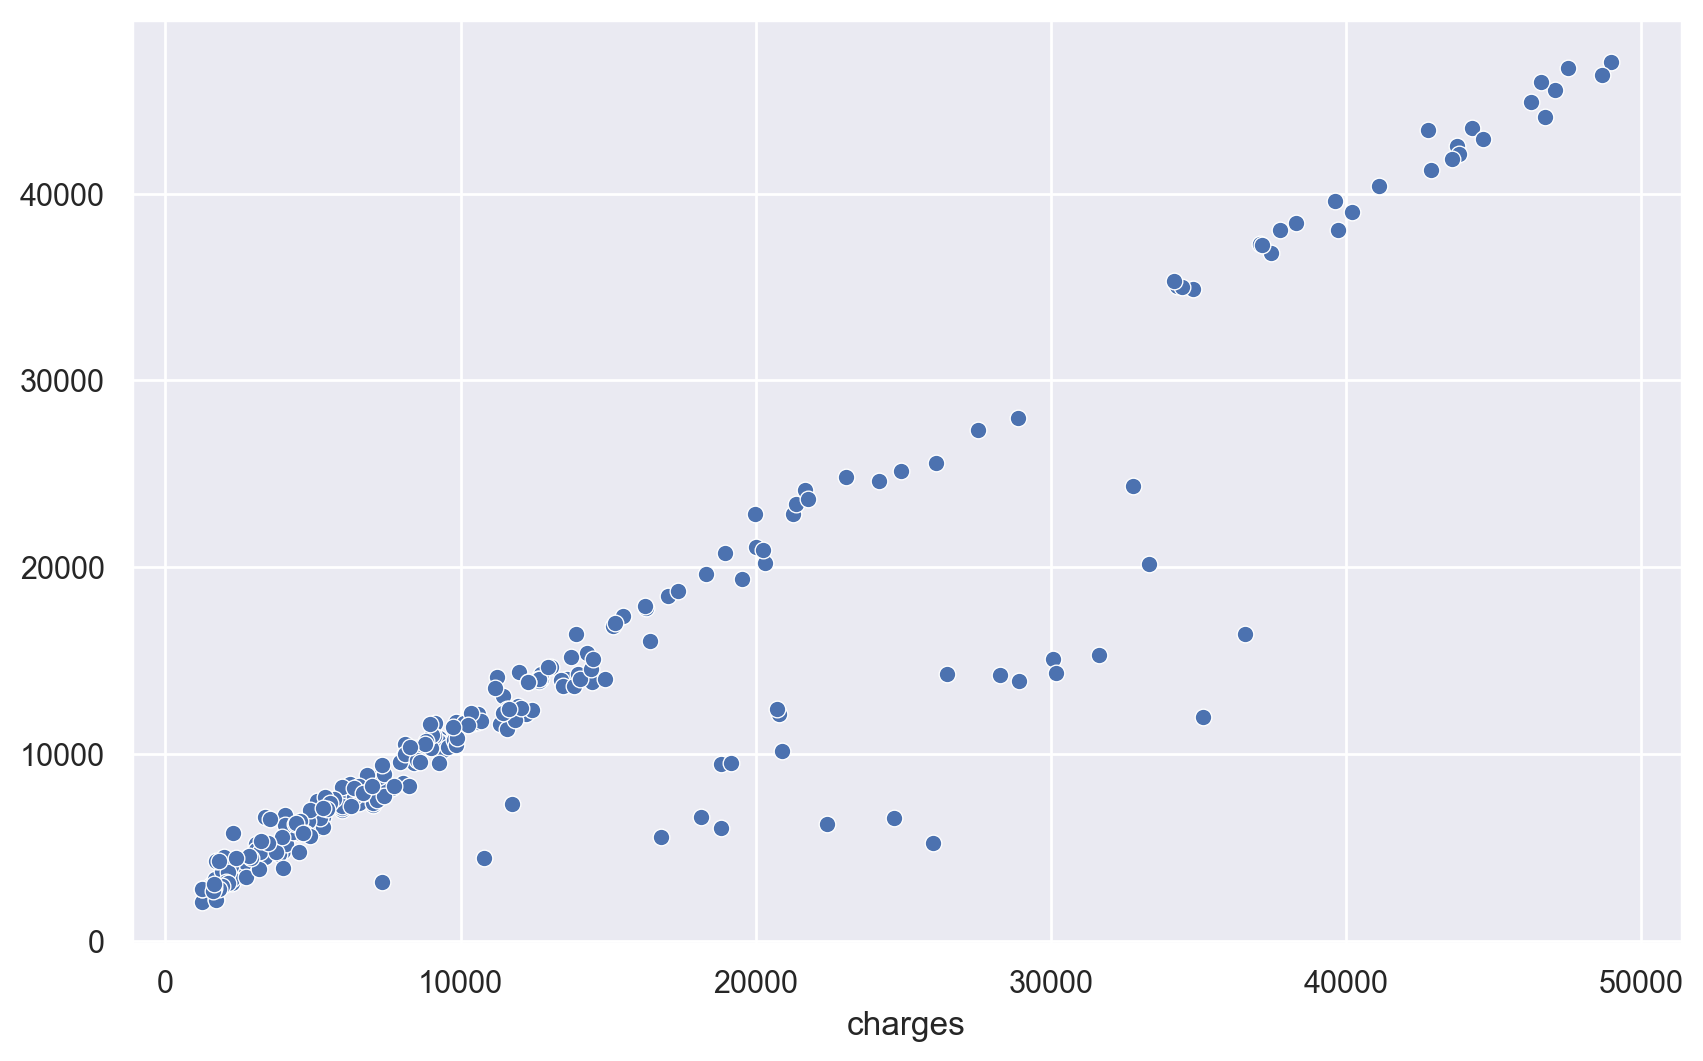

In [90]:
pred=bayes.predict(x_test)
plt.figure(figsize=(10,6),dpi=200)
sns.scatterplot(x=y_test, y=pred)

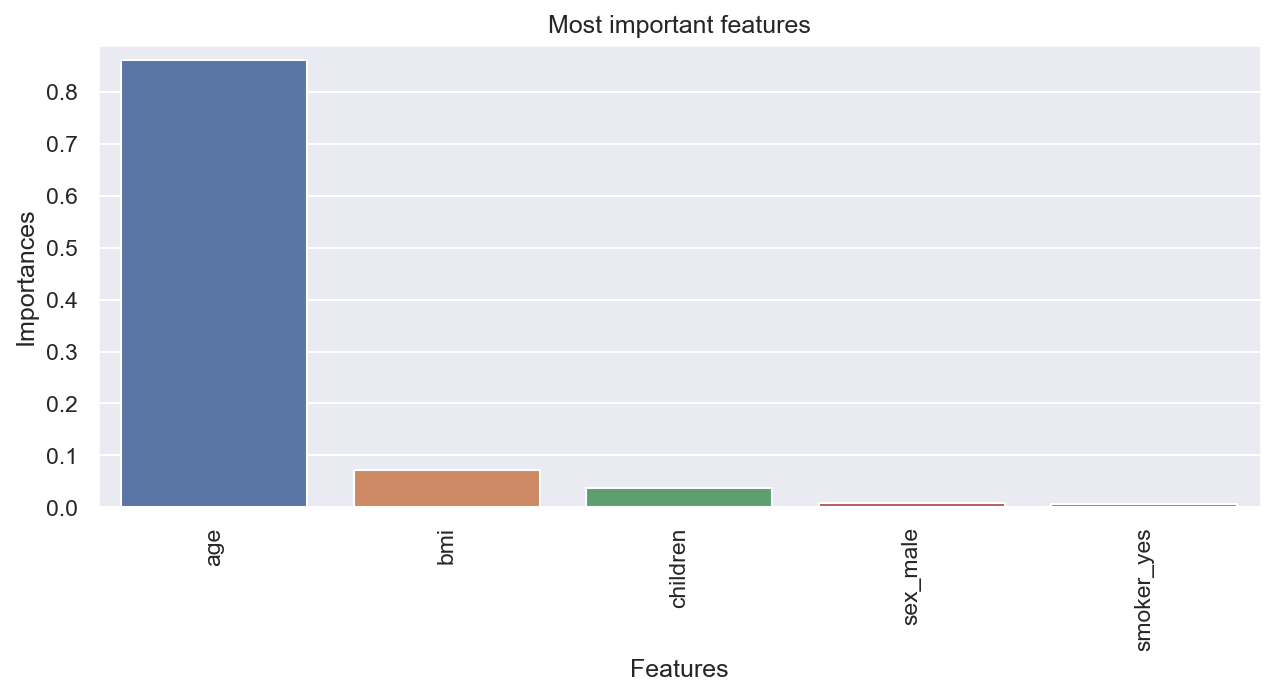

In [99]:
feat=np.abs(pd.DataFrame(bayes.best_estimator_.feature_importances_, columns=["Importances"])).sort_values(by='Importances', ascending=False)
feat['Features']=X.columns
# feat.head(20)
plt.figure(figsize=(10,4),dpi=150)
sns.barplot(data=feat.head(5), x="Features", y="Importances")
plt.xticks(rotation=90);
plt.ylim(0,0.89)
plt.title("Most important features");